In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Rectangle,Polygon
from matplotlib.gridspec import GridSpec

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

import os,glob,re
import numpy as np
from Bio import SeqIO
from collections import Counter

import baltic as bt

travel={}
for line in open('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/travel_qc_info.csv','r'):
    l=line.strip('\n').split('\t')
#     print(l[3])
    if l[0]!='Virus name' and l[4]!='':
        travel[l[0]]=l[4]


base_path='/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/alignments/B.1.620_repr_Cameroon_wRef.fasta'

seqs={}
seq_order=[]
for seq in SeqIO.parse(base_path,format='fasta'):
    
    seqs[seq.id]=str(seq.seq).replace('U','T')
    seq_order.append(seq.id)
#     print(seq.id,len(seq.seq))
    
ref='NC_045512'

ll=bt.loadNexus('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/trees/B.1.620_repr_Cameroon_wRef_renamed.tre',absoluteTime=False,tip_regex='[A-Za-z0-9]+',treestring_regex='tree con_50_majrule =')

rename={}
for line in open('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/trees/B.1.620_repr_Cameroon_wRef.fasta_names_keyfile.txt','r'):
    key,val=line.strip('\n').split('@')
    rename[key[1:]]=val[1:]
    
for k in ll.getExternal():
    k.name=rename[k.name]

for k in ll.Objects:
    k.length=k.length*len(seq.seq)
    
ll=ll.collapseBranches(lambda k: k.length==0)
ll.sortBranches(descending=False)
# ll.treeStats()

alnL=max(list(map(len,seqs.values())))

variable=[]

# focus_sequences=[f for f in seqs if f.split('|')[0] in travel]
travel_cases=[s for s in seqs if s.split('|')[0] in travel]
ca=ll.commonAncestor(ll.getExternal(lambda k: k.name in travel_cases))
focus_sequences=list(ca.leaves)


for i in range(alnL): ## iterate over alignment columns
    if len(set([s[i] for s in seqs.values() if s[i] in ['A','C','T','G','-']]))>1: ## polymorphic site
        column=[s[i] for s in seqs.values() if s[i] in ['A','C','T','G','-']] ## get column states
        VOI_column=[seqs[s][i] for s in focus_sequences if seqs[s][i] in ['A','C','T','G','-']]
#         print(i,VOI_column)
        if min(Counter(column).values())>1 and min(Counter(VOI_column).values())>1: ## column polymorphic and shared by at least two sequences
            variable.append(i)

variable=list(filter(lambda i: i>100,variable))
variable=list(filter(lambda i: i<29903-50,variable))

# SNPs={s: {i: seqs[s][i] for i in variable} for s in seqs} ## get all variable sites

SNPs={s: {i: seqs[s][i] for i in variable if any([seqs[f][i]!=seqs[ref][i] and seqs[f][i] in ['A','C','T','G','-'] for f in focus_sequences])} for s in seqs}

variable=sorted(list(SNPs[ref].keys()))

print(variable)

[240, 957, 1472, 3036, 4964, 6235, 7833, 8315, 11287, 11288, 11289, 11290, 11291, 11292, 11293, 11294, 11295, 14407, 15323, 15345, 17109, 17678, 17745, 18672, 20048, 21637, 21764, 21765, 21766, 21767, 21768, 21769, 21938, 21990, 21991, 21992, 22280, 22281, 22282, 22283, 22284, 22285, 22286, 22287, 22288, 22294, 22497, 22991, 23011, 23402, 23415, 23603, 24641, 24913, 25032, 25431, 25432, 25433, 25434, 25435, 25915, 26526, 26881, 27640, 27794, 27795, 27796, 28270, 28296, 28931]


In [2]:
def convert_deletions(deletions):
    formatted=[]
    
    if len(dels)>0:
        for d in dels:
            ds=d.split('-')
            if len(ds)>1:
#                     print('span',ds)
                b,e=map(int,ds)
                for i in range(b,e):
                    formatted.append('X%s-'%(i))
                
    return formatted

ORFs={"E": (26244,26472), 
      "M": (26522,27191), 
      "N": (28273,29533), 
      "ORF10": (29557,29674), 
#       "ORF14": (28733,28955), 
      "ORF1a": (265,13468), 
      "ORF1b": (13467,21555), 
      "ORF3a": (25392,26220), 
      "ORF6": (27201,27387), 
      "ORF7a": (27393,27759), 
      "ORF7b": (27755,27887), 
      "ORF8": (27893,28259), 
      "ORF9b": (28283,28577), 
      "S": (21562,25384)}

def id_orf(site):
    orf={}
    for gene in ORFs:
        m,M=ORFs[gene]
        
        if m<=site<=M:
            orf[gene]=[m,M]
            
    return orf


def match_aa(nt,aa):
    
    matched={}
    
    for mut in nt:
        site=int(mut[1:-1])
        orfs=id_orf(site)
        
        if len(orfs)==0: ## no orf, nucleotide
            matched[site]='%s'%(site) ## just site, no aa change
            
        for gene in orfs: ## iterate over ORFs
            m,M=orfs[gene] ## beginning and end of ORF

            codon=(((site-m-1))//3)+1 ## get codon in ORF
            mut_search=re.compile('%s:[A-Z*-]%d[A-Z*-]'%(gene,codon)) ## form regex search for match

            search=[mut_search.match(aa_mut) for aa_mut in aa] ## search amongst aa mutations for match

            candidates=[]
            for candidate in search: ## iterate over searches
                if candidate: ## match is not None
                    candidates.append(candidate.group()) ## remember candidate
            
            if len(candidates)==1: ## one candidate found - great
#                         print(mut,gene,codon,candidates[0])
#                 if site in nt2aa and site-1 in variable:
#                     if '%s (%s)'%(site,candidates[0])!=nt2aa[site]:
#                         print('different mutation: %s %s'%('%s (%s)'%(site,candidates[0]),nt2aa[site]))
#                             print(nt2aa[site],)
                matched[site]='%s (%s)'%(site,candidates[0])
            elif len(candidates)==0: ## no good candidates found - synonymous
                matched[site]='%s'%(site)
            else:
                print('problematic mutation %s with multiple candidates %s'%(mut,candidates))
    
    return matched



nt2aa={}
for line in open('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/alignments/B.1.620_repr_Cameroon_wRef.nextclade.tsv','r'):
    l=line.strip('\n').split('\t')
#     print(l)
#     print(l)
    if l[0]=='seqName':
        header={x: i for i,x in enumerate(l)}
    elif l[0]!=ref:
#         print(l[0])
        
        AAs=l[header['aaSubstitutions']].split(',')+l[header['aaDeletions']].split(',')
        NTs=l[header['substitutions']].split(',')
        dels=l[header['deletions']].split(',')
        
#         print(convert_deletions(dels))
        NTs+=convert_deletions(dels)
        keep_nt=[]
        for nt in NTs:
            site=int(nt[1:-1])
            if site-1 not in variable: ## not interested in converting, not in plot
#                 print('%s not in variable'%(nt))
                pass
            else: ## site is in plot, need to convert
                pass
                keep_nt.append(nt)
#                 print('%s in plot'%(nt))
        
        matched_up=match_aa(keep_nt,AAs)
#         print(l[0])
        for i in matched_up:
            if i not in nt2aa:
                nt2aa[i]=matched_up[i]
            elif nt2aa[i]!=matched_up[i]:
                print('different',nt2aa[i],matched_up[i])
            else:
                pass
            
print(nt2aa)


nt2aa[21765]='21765' ## beginning of H69 deletion

nt2aa[21991]='21991 (S:Y144-)' ## Y144 deletion missed entirely
nt2aa[21992]='21992 (S:Y144-)'
nt2aa[21993]='21993 (S:Y144-)'

nt2aa[22295]='22295 (S:H245Y)'

nt2aa[22281]='22281' ## beginning of L241 deletion
nt2aa[22282]='22282'

nt2aa[22283]='22283 (S:L241-)'
nt2aa[22284]='22284 (S:L241-)'
nt2aa[22285]='22285 (S:L241-)'

nt2aa[22287]='22287 (S:L242-)'
nt2aa[22288]='22288 (S:L242-)'

nt2aa[25432]='25432 (ORF3a:T14-)'
nt2aa[25433]='25433 (ORF3a:T14-)'
nt2aa[25434]='25434 (ORF3a:T14-)'

inter_orf_breaks=[]
store=None
for i in variable:
    
    Os=id_orf(i)
    orf=list(Os.keys())[0] if len(Os)>0 else None
    
    if store and store!=orf:
        inter_orf_breaks.append(i)
        
    store=orf
print(inter_orf_breaks)

different 23604 (S:P681H) 23604 (S:P681R)
different 23604 (S:P681H) 23604 (S:P681R)
different 22287 (S:L242H) 22287 (S:L242-)
different 22288 (S:L242H) 22288 (S:L242-)
different 22295 (S:H245-) 22295 (S:H245X)
different 22287 (S:L242H) 22287 (S:L242-)
different 22288 (S:L242H) 22288 (S:L242-)
different 22295 (S:H245-) 22295 (S:H245X)
different 22287 (S:L242H) 22287 (S:L242-)
different 22288 (S:L242H) 22288 (S:L242-)
different 22295 (S:H245-) 22295 (S:H245X)
different 22287 (S:L242H) 22287 (S:L242-)
different 22288 (S:L242H) 22288 (S:L242-)
different 22295 (S:H245-) 22295 (S:H245X)
different 22287 (S:L242H) 22287 (S:L242-)
different 22288 (S:L242H) 22288 (S:L242-)
different 22295 (S:H245-) 22295 (S:H245X)
different 22287 (S:L242H) 22287 (S:L242-)
different 22288 (S:L242H) 22288 (S:L242-)
different 22295 (S:H245-) 22295 (S:H245X)
different 22287 (S:L242H) 22287 (S:L242-)
different 22288 (S:L242H) 22288 (S:L242-)
different 22295 (S:H245-) 22295 (S:H245X)
different 22287 (S:L242H) 22287 (S

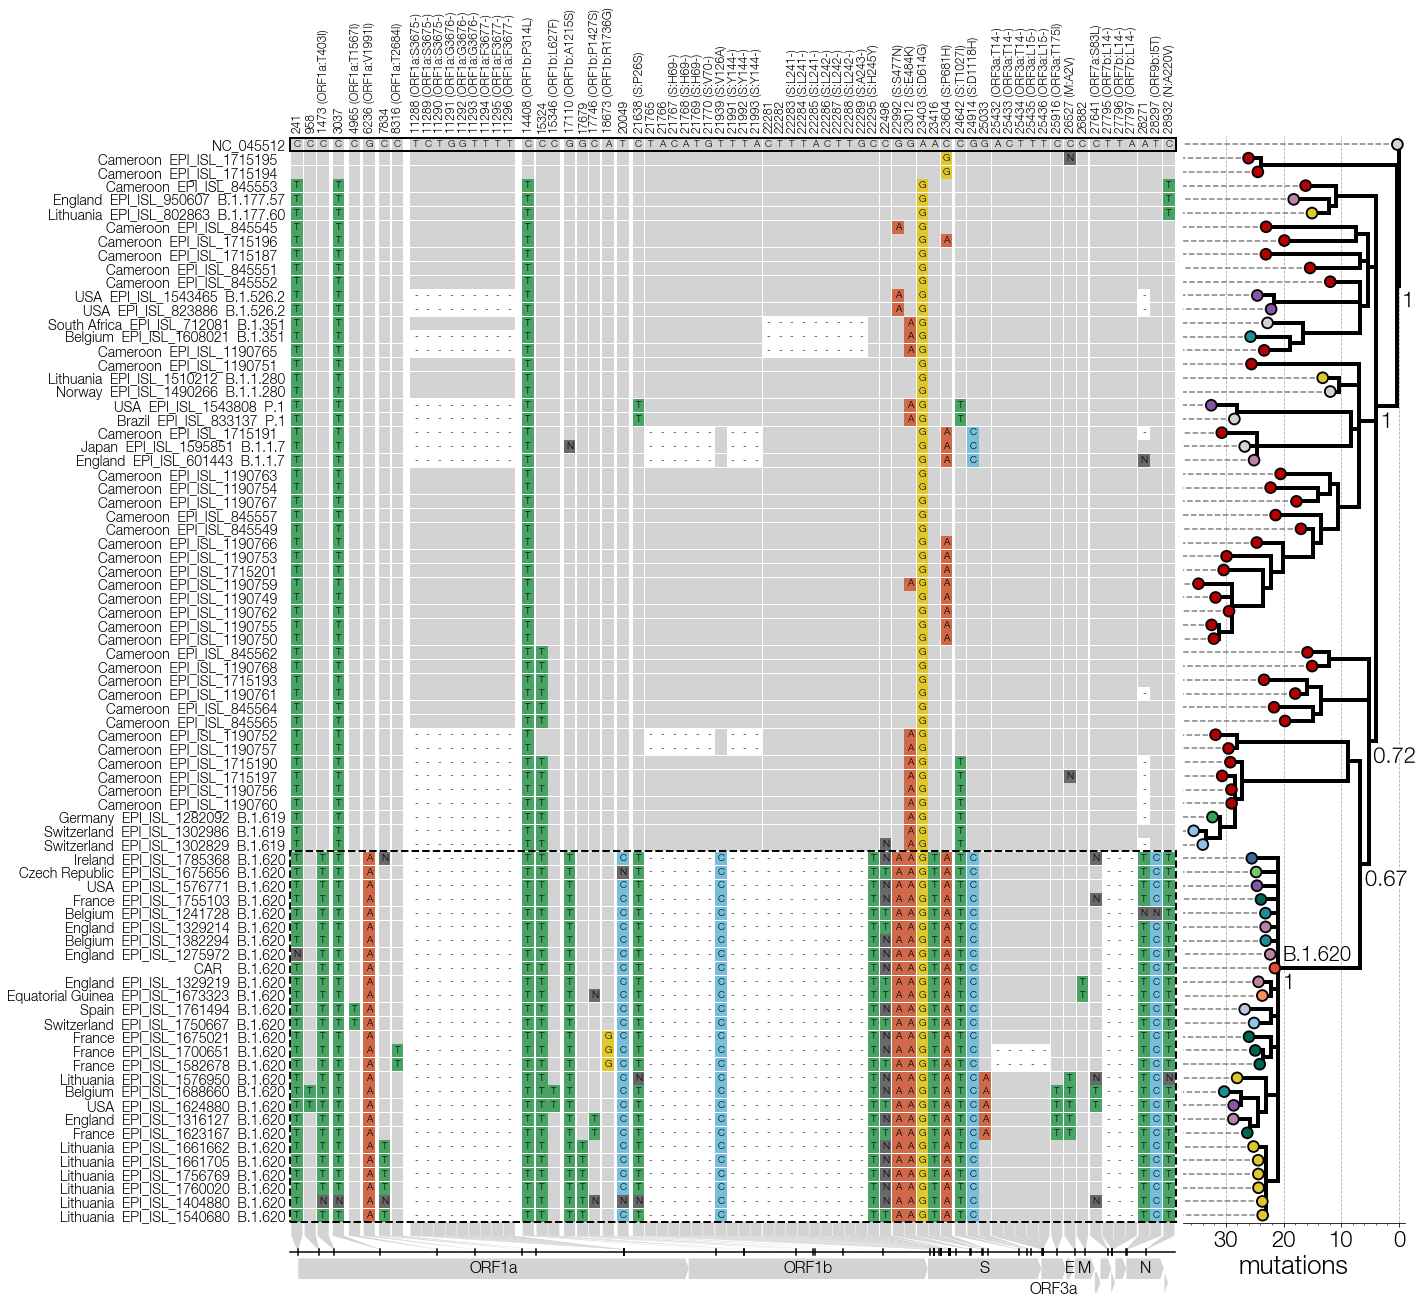

In [3]:
fig = plt.subplots(figsize=(20,20),facecolor='w')

gs = GridSpec(1,2,width_ratios=[8,2],hspace=0.01,wspace=0.01)
ax=plt.subplot(gs[0])

colours={'A': '#D0694A', 'C': '#77BEDB', 'T': '#48A365', 'G': '#E1C72F', 
         '-':'w','N':'dimgrey', 
         'K': 'dimgrey', 'Y': 'dimgrey', 'M': 'dimgrey', 'W': 'dimgrey', 'R': 'dimgrey'}

# seq_order=list(SNPs.keys())
# seq_order=sorted(list(SNPs.keys()),key=lambda w: w.split('|')[0])

window=3
ll.sortBranches()
seq_order=[k.name for k in sorted(ll.getExternal(),key=lambda w: w.y)]

for s,S in enumerate(seq_order):
    cumulative_x=-1
    store_site=0
    xticks=[]
    
    h=0.95
    w=1.0
    
    for i,nt in enumerate(SNPs[S]):
        fc=colours[seqs[S][nt]]
        
        if store_site+window<nt: ## next site is beyond window
            cumulative_x+=1+(nt-store_site)*0.0002
        else:
            cumulative_x+=1
        
        if S==ref or SNPs[S][nt]==SNPs[ref][nt]:
            fc='lightgrey'
            
        rect=Rectangle((cumulative_x,s),w,h,facecolor=fc,edgecolor='none')
        ax.add_patch(rect)
        
        if S==ref or SNPs[S][nt]!=SNPs[ref][nt]: ## nucleotide different from reference or at reference
            ax.text(cumulative_x+0.5,s+0.5,seqs[S][nt],size=10,ha='center',va='center')
        
        xticks.append(cumulative_x)
        store_site=nt
        
    if S=='MN908947.3' or S==ref:
        ax.add_patch(Rectangle((0,s),cumulative_x+1.1,h,facecolor='none',edgecolor='k',lw=2))
        

ax.add_patch(Rectangle((0,0),cumulative_x+1.1,len([k for k in ll.getExternal() if k.name in focus_sequences]),facecolor='none',edgecolor='k',lw=2,ls='--',zorder=1000))
        
norm=mpl.colors.Normalize(1,alnL)

for site,nt in zip(xticks,variable):
    y=-1
    skip=1
    tick_size=0.4
    low_y=y-skip
    f=0.02
    point=(nt/alnL)*(cumulative_x+1)
    
    A=(site+f,0)
    B=(site+f,y)
    C=(point-0.05,low_y)
    D=(point+0.05,low_y)
    E=(site+1-f,y)
    F=(site+1-f,0)
    
    ax.add_patch(Polygon([A,B,C,D,E,F],facecolor='lightgrey',edgecolor='none',clip_on=False))
    
    ax.plot([point,point],[low_y,low_y-tick_size],color='k',clip_on=False)
    
    
ax.plot([0,cumulative_x+1],[low_y-tick_size/2,low_y-tick_size/2],color='k',clip_on=False)
for o in sorted(ORFs,key=lambda s: s[0]):
    b,e=ORFs[o]
    
    begin=(b/alnL)*(cumulative_x+1)
    end=(e/alnL)*(cumulative_x+1)
    offset=2.4
    w=1.5
    kwargs={'width': w, 
            'length_includes_head': True, 
            'head_width': w, 
            'head_length': 0.3, 
            'clip_on': False}
    if (e-b)<200:
        offset=3.4
    elif '7' in o or '8' in o or '9' in o:
        pass
#         ax.text(np.mean([begin,end]),y-offset-w,o,size=20,color='k',ha='center',va='top',zorder=1000,clip_on=False)
    elif '3' in o:
        ax.text(np.mean([begin,end]),y-offset-w,o,size=16,color='k',ha='center',va='center',zorder=1000,clip_on=False)
    else:
        ax.text(np.mean([begin,end]),y-offset,o,size=16,color='k',ha='center',va='center',zorder=1000,clip_on=False)
    
    ax.arrow(begin,y-offset,end-begin,0,facecolor='lightgrey',edgecolor='none',**kwargs)


ax.xaxis.tick_top()
ax.set_xticks([x+0.55 for x in xticks])
### ax.set_xticklabels([site+1 for site in variable],size=14,rotation=90)
ax.set_xticklabels([nt2aa[site+1] if site+1 in nt2aa else 'XXXXXXX absent %s'%(site+1) for site in variable],size=12,rotation=90)

ax.set_yticks([y+0.5 for y in range(len(seqs))])


yticklabels=[]
for y in seq_order:

    lin=None
    
    if y!=ref:
        if len(y.split('|'))==4:
            strain=y.split('|')[1]
            acc=y.split('|')[2]
            lin=y.split('|')[0]

        elif len(y.split('|'))==3:
            strain=y.split('|')[0]
            acc=y.split('|')[1]
            lin='B.1.620' if y in focus_sequences else ''
        
        country=strain.split('/')[1]
        country=country.replace('_',' ')
        
        y='%s\t\t%s\t\t%s'%(country,acc,lin)
        
    elif len(y.split('|'))==3:
        acc=y.split('|')[1]
        y=y.split('|')[0] ## strain name
        
        country=y.split('/')[1] ## country
        y='%s\t\t%s\t\t%s'%(country,acc,' ')
    
    yticklabels.append(y)

ax.set_yticklabels(yticklabels,size=14)
ax.tick_params(size=0)

ax.set_xlim(min(xticks)-0.2,cumulative_x+1.2)
ax.set_ylim(-0.1,len(seqs)+0.1)

[ax.spines[loc].set_visible(False) for loc in ax.spines]


ax2=plt.subplot(gs[1])

ll.plotTree(ax2,width=4)

colours={}
for line in open('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/colours.csv','r'):
    loc,colour=line.strip('\n').split('\t')
    colours[loc]=colour

for k in ll.getExternal():
    ax2.plot([k.height,50],[k.y,k.y],ls='--',color='grey',zorder=90)
    
    s=80
    ec='none'
    country=None
    
    if len(k.name.split('|'))==4:
        strain=k.name.split('|')[1]
        country=strain.split('/')[1]
        lin=k.name.split('|')[0]
        
    elif len(k.name.split('|'))==3:
        strain=k.name.split('|')[0]
        lin='B.1.620' if strain in travel else ''
        country=strain.split('/')[1]
    
    if country:
        country=country.replace('_',' ')
    
    fc=colours[country] if country in colours else 'lightgrey'
    
    ax2.scatter(k.height,k.y,s=s,facecolor=fc,edgecolor=ec,zorder=100)
    ax2.scatter(k.height,k.y,s=s*2,facecolor='k',edgecolor=ec,zorder=99)
    
    
for k in ll.getInternal():
    if len(k.leaves.intersection(set(focus_sequences)))>0 and len(k.leaves)>=len(focus_sequences) and len(k.traits)>0:
        effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                     path_effects.Stroke(linewidth=0, foreground='k')] ## black text, white outline
    
        prob='%.2f'%(k.traits['prob']) if k.traits['prob']<1.0 else '1'
        ax2.text(k.height-0.8,k.y-0.4,prob,size=22,path_effects=effects,ha='left',va='top')

    if len(k.leaves.intersection(set(focus_sequences)))==len(focus_sequences)==len(k.leaves):
        ax2.text(k.height-0.8,k.y+0.2,'B.1.620',ha='left',va='bottom',size=20)
    
ax2.invert_xaxis()
ax2.plot()
ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))

[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['bottom']]
ax2.tick_params(axis='y',size=0,labelsize=0)
ax2.set_ylim(-0.1,len(seqs)+0.1)
ax2.set_xlim(37.5,-1)
ax2.grid(axis='x',ls='--')
ax2.set_xlabel('mutations',size=26)

# plt.savefig('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/figures/Fig1_mutations.png',dpi=100,bbox_inches='tight')
plt.savefig('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/figures/Fig1_mutations.pdf',dpi=100,bbox_inches='tight')
plt.show()